## Average Backers and Pledged by Main Category

#### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark import SparkContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, avg , sum
import findspark

#### Start session

In [5]:
# Context
SparkContext = SparkContext()

# Session
spark = SparkSession \
    .builder \
    .appName("Kickstarter Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#### Load the Data into a Spark DataFrame

In [39]:
findspark.init()

df = spark.read.csv("kick_starter_cleaned.csv", header = True,  inferSchema=True)

df.head()

Row(name='The Songs of Adelaide & Abullah', category='Poetry', main_category='Publishing', currency='GBP', deadline='2015-10-09', goal='1000.0', launched='2015-08-11 12:12:28', pledged='0.0', state='failed', backers='0', country='GB', usd_pledged_real='0.0', usd_goal_real='1533.95')

In [7]:
# show distinct countries in spark df
# df = spark.createDataFrame(df)
# df.select('country').distinct().show()

In [8]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



In [19]:
df.show(15)

+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|                name|      category|main_category|currency|  deadline|    goal|           launched|pledged|     state|backers|country|usd_pledged_real|usd_goal_real|
+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|The Songs of Adel...|        Poetry|   Publishing|     GBP|2015-10-09|  1000.0|2015-08-11 12:12:28|    0.0|    failed|      0|     GB|             0.0|      1533.95|
|Greeting From Ear...|Narrative Film| Film & Video|     USD|2017-11-01| 30000.0|2017-09-02 04:43:57| 2421.0|    failed|     15|     US|          2421.0|      30000.0|
|      Where is Hank?|Narrative Film| Film & Video|     USD|2013-02-26| 45000.0|2013-01-12 00:20:50|  220.0|    failed|      3|     US|           220.0|      45000.0

In [40]:
# show the number of distinct countries using spark
df.select('category').distinct().count()

1434

In [32]:
# show them starting with the least frequent
df.groupBy('category').count().orderBy('count').show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
| It's Rocket Scie...|    1|
| mind-bending hor...|    1|
|                   7|    1|
| Iran and Turkey/...|    1|
| of the Other"" [...|    1|
|            "" a CD"|    1|
|          NY Harbor"|    1|
|             LONDON"|    1|
|          Score! Tap|    1|
|    I'm Not Sorry"""|    1|
|            ART BOOK|    1|
| A Familiar Love ...|    1|
| Green Light"" in...|    1|
|            Chicago"|    1|
| an art show abou...|    1|
|  there's your quote|    1|
| my third music C...|    1|
| part one: Just D...|    1|
|        about Prince|    1|
| WE DON'T!""  -LG...|    1|
+--------------------+-----+
only showing top 20 rows



After reviewing the dataset, I found out there is a problem with names that have a comma in them as the rest of the name gets put in the next column and so on, making the data very wrong, in my case I'm going to remove the columns with main category that have 1 entry, because it's probably one of the rows with the wrong format.

### Identify Main Categories with Only One Entry

In [42]:
from pyspark.sql import functions as F

# Group by category and count the number of entries for each
category_counts = df.groupBy('category').count()

# Filter to get categories that have only one entry
single_entry_categories = category_counts.filter(F.col('count') == 1).select('category')

# Collect the results into a list
single_entry_categories_list2 = [row.category for row in single_entry_categories.collect()]

# Print the list of categories with only one entry
print(single_entry_categories_list2)

['7', ' Iran and Turkey/Anatolia"', " there's your quote", '"" a CD"', ' Premium Aluminum Case for the iPad"', ' LONDON"', ' part one: Just Desserts"""', ' I\'m Not Sorry"""', ' ART BOOK', ' Green Light"" in its second festival!"', ' Syria"" (Canceled)"', ' Chicago"', ' mind-bending horror feature"', ' of the Other"" [A New Short Video Work]"', ' NY Harbor"', ' Score! Tap', ' an art show about tennis."', ' my third music CD... a forests\' symphony."', ' about Prince', ' A Familiar Love Song"""', ' WE DON\'T!""  -LGH.tv"', ' It\'s Rocket Science!"" by Bob Windt"', ' A Generations Guide To Retirement"""', ' an original dance opera by Kimmie & Enoch Chan"', 'Umbrella#Parapluie#animal#mode#urban#jungle#fun"', ' a feature documentary"', ' Crazy"" by Jason Kerzinski"', ' You Can Eat Nuts Again!"" GF"', '"" Science Fiction Short Story"', ' a short thriller. (Canceled)"', ' Pretty Boys & Nappy Hair"""', ' Death"" Graphic Novel"', ' Officer"" Data Saviors Project"', ' a Mayan adventure film"', 

In [43]:
# how many values are in single_entry_categories_list
len(single_entry_categories_list2)

1260

In [44]:
# Filter out the rows that have a main category in the single_entry_categories_list
df = df.filter(~df['category'].isin(single_entry_categories_list2))

# Show the result to ensure rows are filtered correctly
df.show()

+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|                name|      category|main_category|currency|  deadline|    goal|           launched|pledged|     state|backers|country|usd_pledged_real|usd_goal_real|
+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|The Songs of Adel...|        Poetry|   Publishing|     GBP|2015-10-09|  1000.0|2015-08-11 12:12:28|    0.0|    failed|      0|     GB|             0.0|      1533.95|
|Greeting From Ear...|Narrative Film| Film & Video|     USD|2017-11-01| 30000.0|2017-09-02 04:43:57| 2421.0|    failed|     15|     US|          2421.0|      30000.0|
|      Where is Hank?|Narrative Film| Film & Video|     USD|2013-02-26| 45000.0|2013-01-12 00:20:50|  220.0|    failed|      3|     US|           220.0|      45000.0

In [45]:
from pyspark.sql import functions as F

# Group by main_category and count the number of entries for each
category_counts = df.groupBy('main_category').count()

# Filter to get main categories that have only one entry
single_entry_categories = category_counts.filter(F.col('count') == 1).select('main_category')

# Collect the results into a list
single_entry_categories_list = [row.main_category for row in single_entry_categories.collect()]

# Print the list of main categories with only one entry
print(single_entry_categories_list)

[' theatre"', "Children's Books", 'Public Art', ' and poetry"', ' Things"""', 'Painting', 'Apps', 'Sculpture', 'Apparel', 'Illustration', 'Country & Folk', 'Webseries', 'People', 'TV Show', ' TV Show', 'Software', ' and Things"" - A Blue View Cinema short film"', 'Comedy', 'Web', 'Narrative Film']


In [46]:
# how many values are in single_entry_categories_list
len(single_entry_categories_list)

20

In [47]:
# Filter out the rows that have a main category in the single_entry_categories_list
df = df.filter(~df['main_category'].isin(single_entry_categories_list))

# Show the result to ensure rows are filtered correctly
df.show()

+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|                name|      category|main_category|currency|  deadline|    goal|           launched|pledged|     state|backers|country|usd_pledged_real|usd_goal_real|
+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+----------+-------+-------+----------------+-------------+
|The Songs of Adel...|        Poetry|   Publishing|     GBP|2015-10-09|  1000.0|2015-08-11 12:12:28|    0.0|    failed|      0|     GB|             0.0|      1533.95|
|Greeting From Ear...|Narrative Film| Film & Video|     USD|2017-11-01| 30000.0|2017-09-02 04:43:57| 2421.0|    failed|     15|     US|          2421.0|      30000.0|
|      Where is Hank?|Narrative Film| Film & Video|     USD|2013-02-26| 45000.0|2013-01-12 00:20:50|  220.0|    failed|      3|     US|           220.0|      45000.0

all the rows removed are less than 1%

In [50]:
# Average number of backers for each main category in descending order
df.groupBy('main_category').agg(avg('backers')).orderBy('avg(backers)', ascending = False).show(15)

+-------------+------------------+
|main_category|      avg(backers)|
+-------------+------------------+
|        Games| 322.0539265825662|
|       Design|  241.623438488957|
|   Technology|164.64871014359068|
|       Comics|134.95568740150182|
| Film & Video| 67.10063124839785|
|      Fashion| 61.52260755048288|
|   Publishing|56.798201006822886|
|        Music| 54.67920964990659|
|         Food| 54.20373611167636|
|      Theater| 47.17613320999075|
|        Dance| 42.71787336361208|
|          Art| 42.25247701190391|
|  Photography| 39.72018604651163|
|   Journalism|38.399873391010765|
|       Crafts|27.304283604135893|
+-------------+------------------+
only showing top 15 rows



### visualization

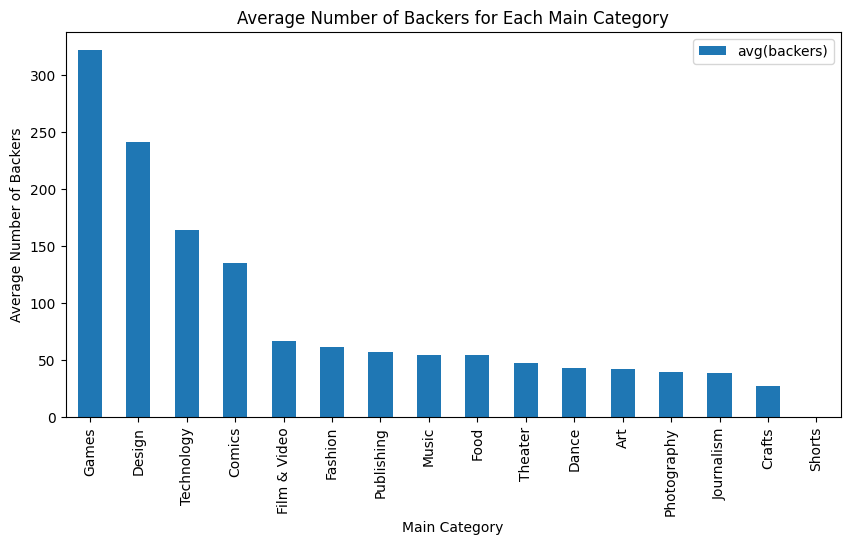

In [51]:
# visulization of the average number of backers for each main category
df.groupBy('main_category').agg(avg('backers')).orderBy('avg(backers)', ascending = False).toPandas().plot(kind='bar', x='main_category', y='avg(backers)', figsize=(10,5))
plt.title('Average Number of Backers for Each Main Category')
plt.ylabel('Average Number of Backers')
plt.xlabel('Main Category')
plt.show()

### As we can see Games are the most attractive category for backers

In [52]:
# Average Pledged amount for each main category in descending order
df.groupBy('main_category').agg(avg('usd_pledged_real')).orderBy('avg(usd_pledged_real)', ascending = False).show(15)

+-------------+---------------------+
|main_category|avg(usd_pledged_real)|
+-------------+---------------------+
|       Design|   24451.019272793892|
|   Technology|   21081.877071303385|
|        Games|   21058.912924764187|
|       Comics|    6618.460622045051|
| Film & Video|    6229.669476736733|
|      Fashion|    5717.050019315188|
|         Food|    5117.561564852871|
|      Theater|    4016.680606845512|
|        Music|   3909.9348643489534|
|  Photography|   3573.2795758139528|
|        Dance|   3447.3405744055576|
|   Publishing|   3394.1176104566443|
|          Art|    3224.096275572029|
|   Journalism|    2622.990436801013|
|       Crafts|   1634.2167742302013|
+-------------+---------------------+
only showing top 15 rows



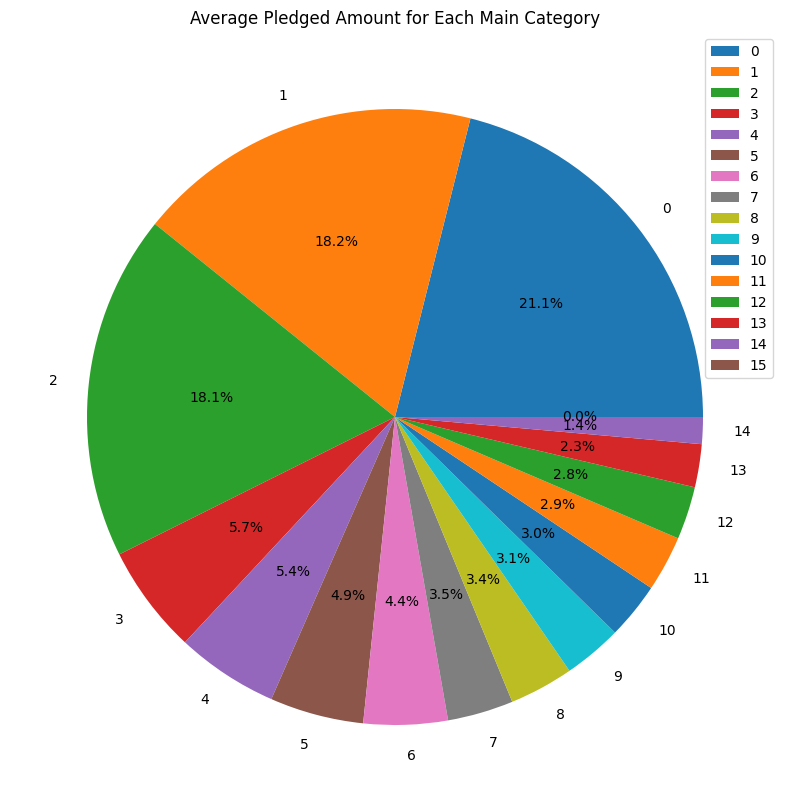

In [67]:
df.groupBy('main_category').agg(avg('usd_pledged_real')).orderBy('avg(usd_pledged_real)', ascending = False).toPandas().plot.pie(y='avg(usd_pledged_real)', autopct='%1.1f%%', figsize=(10, 10))
plt.title('Average Pledged Amount for Each Main Category')
plt.ylabel('')
plt.show()